In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import cross_val_score, StratifiedKFold


In [3]:
train_df=pd.read_csv("/kaggle/input/titanic/train.csv")
test_df=pd.read_csv("/kaggle/input/titanic/test.csv")

In [4]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train_df.groupby(['Sex'],as_index=False)['Survived'].mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [7]:
train_df.groupby(['Sex'],as_index=False)['Survived'].mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [8]:
train_df.groupby(['Parch'],as_index=False)['Survived'].mean()

,Parch,Survived
0,0,0.343658
1,1,0.550847
2,2,0.500000
3,3,0.600000
4,4,0.000000
5,5,0.200000
6,6,0.000000


In [9]:
train_df.groupby(['SibSp'],as_index=False)['Survived'].mean()

,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [10]:
#we create a family_size coloumn by  adding spouse and children coloumn
train_df['Family_Size']= train_df['SibSp']+ test_df['Parch']+1


test_df['Family_Size']= test_df['SibSp']+ test_df['Parch']+1


In [11]:
train_df.groupby(['Family_Size'],as_index=False)['Survived'].mean()

,Family_Size,Survived
0,1.0,0.384615
1,2.0,0.509434
2,3.0,0.358974
3,4.0,0.238095
4,5.0,0.294118
5,6.0,0.000000
6,7.0,0.000000
7,9.0,0.000000
8,10.0,0.000000
9,11.0,0.000000


In [12]:
family_map ={1: 'Alone',2:'Small',3:'Small',4:'Small',5:'Medium', 6:'Medium',7:'Large',9:'Large',10:'Large',11:'Large'}

In [13]:
train_df['Family_Size_Grouped']= train_df['Family_Size'].map(family_map)
test_df['Family_Size_Grouped']= test_df['Family_Size'].map(family_map)
print("coloumn created")

coloumn created


In [14]:
train_df.groupby(['Embarked'],as_index=False)['Survived'].mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


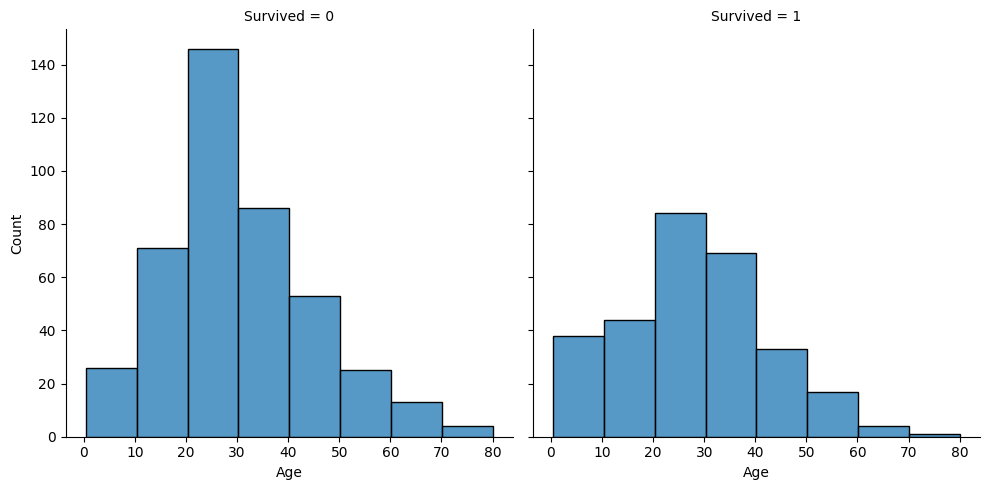

In [15]:
sns.displot(train_df, x='Age', col='Survived', binwidth=10, height=5)


In [16]:
#creating age frequency 

train_df['Age_Cut'] = pd.qcut(train_df['Age'],8)
test_df['Age_Cut'] = pd.qcut(test_df['Age'],8)

In [17]:
train_df.groupby(['Age_Cut'],as_index=False)['Survived'].mean()

/tmp/ipykernel_17/1170681542.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df.groupby(['Age_Cut'],as_index=False)['Survived'].mean()


,Age_Cut,Survived
0,"(0.419, 16.0]",0.550000
1,"(16.0, 20.125]",0.341772
2,"(20.125, 24.0]",0.367347
3,"(24.0, 28.0]",0.352941
4,"(28.0, 32.312]",0.416667
5,"(32.312, 38.0]",0.450549
6,"(38.0, 47.0]",0.329545
7,"(47.0, 80.0]",0.415730
